In [1]:
import sys
sys.path.append("..")
from utils import Db
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

In [2]:
db = Db("../cache")
df = db.get_symbols_as_dataframe(['AAPL'])
df['date_time'] = pd.to_datetime(df['date_time'])

plt.rcParams["figure.figsize"] = [9, 6]
%matplotlib notebook

In [3]:
ewmdf = df[df['date_time'] > datetime.now() - timedelta(days=365)]
ewmdf = ewmdf.reset_index()
days_12 = ewmdf['adjusted_close'].ewm(span=12).mean()
days_12 = days_12.reset_index()
days_26 = ewmdf['adjusted_close'].ewm(span=26).mean()
days_26 = days_26.reset_index()

macd_line = pd.DataFrame(days_12['adjusted_close'] - days_26['adjusted_close'], columns=['adjusted_close'])
macd_line.index = ewmdf['date_time']
macd_line = macd_line.reset_index()
signal_line = macd_line['adjusted_close'].ewm(span=9).mean()
signal_line = signal_line.reset_index()
macd_hist = macd_line['adjusted_close'] - signal_line['adjusted_close']
scatter_data = ewmdf[['unix_time', 'adjusted_close', 'date_time']].as_matrix()

buy_signals, sell_signals = [], []
for i, hist in enumerate(macd_line['adjusted_close']):
    if i > 0:
        #buy signal
        if macd_line['adjusted_close'].loc[i - 1] < 0 < hist:
            buy_signals.append(scatter_data[i, 2])
        elif macd_line['adjusted_close'].loc[i - 1] > 0 > hist:
            sell_signals.append(scatter_data[i, 2])

<IPython.core.display.Javascript object>


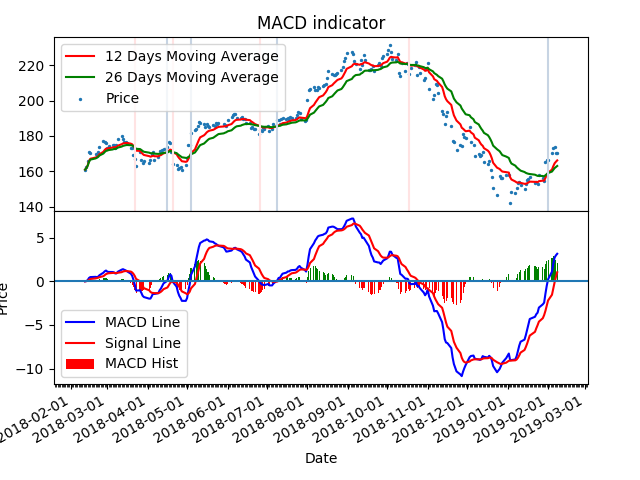

In [4]:
years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
yearsFmt = mdates.DateFormatter('%Y-%m-%d')


fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(scatter_data[:, 2], scatter_data[:, 1].tolist(), label='Price', s=2)
ax.plot(scatter_data[:, 2], days_12['adjusted_close'], label='12 Days Moving Average', color='red')
ax.plot(scatter_data[:, 2], days_26['adjusted_close'], label='26 Days Moving Average', color='green')

for date in buy_signals:
    ax.axvline(date, color=[.78, .83, .89, 1.0])
for date in sell_signals:
    ax.axvline(date, color=[1.0, .89, .89, 1.0])

ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(yearsFmt)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.title('MACD indicator')
plt.legend()

ax = fig.add_subplot(212, sharex=ax)
ax.plot(scatter_data[:, 2], macd_line['adjusted_close'], label='MACD Line', color='blue')
ax.plot(scatter_data[:, 2], signal_line['adjusted_close'], label='Signal Line', color='red')
colors = ["green" if x > 0 else "red" for x in macd_hist]
ax.bar(scatter_data[:, 2], macd_hist, label='MACD Hist', color=colors)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(yearsFmt)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.axhline(0)

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
start_money = 100000.
current_money = start_money
shares = 0.
buy_signals, sell_signals = [], []
for i, current_adjusted_close in enumerate(macd_line['adjusted_close']):
    if i > 0:
        #buy signal
        if macd_line['adjusted_close'].loc[i - 1] < 0 < current_adjusted_close:
            buy_signals.append(scatter_data[i, 2])
            current_price = ewmdf['adjusted_close'].loc[i]
            buying = np.floor(current_money / current_price)
            shares += buying
            current_money -= buying * current_price
        elif macd_line['adjusted_close'].loc[i - 1] > 0 > current_adjusted_close:
            sell_signals.append(scatter_data[i, 2])
            current_price = ewmdf['adjusted_close'].loc[i]
            current_money += current_price * shares
            shares = 0

end_price = ewmdf['adjusted_close'][ewmdf.index[-1]]
extra_money = shares * end_price
current_money += extra_money

start_price = ewmdf['adjusted_close'].loc[0]
start_shares = np.floor(start_money / start_price)
bnh_current_money = start_money - (start_shares * start_price)
end_money = end_price * start_shares 
end_money += bnh_current_money


print("MACD Trading: $" + str(current_money))
print("Buy and Hold: $" + str(end_money))
diff = current_money - end_money
print("MACD vs Buy and Hold: " + "+"+str(diff) if diff > 0 else diff )
print("Profit: " + (str(current_money - start_money)))
print("Number of Trades: " + str(len(buy_signals) + len(sell_signals)))

MACD Trading: $110493.7624
Buy and Hold: $105874.1011
MACD vs Buy and Hold: +4619.6613
Profit: 10493.7624
Number of Trades: 8
